<a href="https://colab.research.google.com/github/SaifullahKatpar/PySpark/blob/master/NY_Taxi_x05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Spark

In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.3.4/spark-2.3.4-bin-hadoop2.7.tgz
!tar xf spark-2.3.4-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.4-bin-hadoop2.7"

import findspark
findspark.init()

In [0]:
from pyspark import SparkConf
SparkConf().set("spark.executor.memory", "13g")

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

--2020-05-26 05:10:08--  https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
Resolving bin.equinox.io (bin.equinox.io)... 3.229.211.71, 52.54.235.191, 52.206.116.16, ...
Connecting to bin.equinox.io (bin.equinox.io)|3.229.211.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13773305 (13M) [application/octet-stream]
Saving to: ‘ngrok-stable-linux-amd64.zip’

ngrok-stable-linux- 100%[===================>]  13.13M  12.8MB/s    in 1.0s    

2020-05-26 05:10:09 (12.8 MB/s) - ‘ngrok-stable-linux-amd64.zip’ saved [13773305/13773305]

Archive:  ngrok-stable-linux-amd64.zip
  inflating: ngrok                   
https://f4e308b4.ngrok.io


In [0]:
# Install dependencies
!pip install pyshp

     |████████████████████████████████| 225kB 9.3MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.0-cp36-none-any.whl size=32609 sha256=557afd0c74dd48c6ad8014dbaf44d32abce1f80fd9893c8b9bb768598e69b4c3
  Stored in directory: /root/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [0]:
# Import the PySpark module
from pyspark.sql import SparkSession

# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('test') \
                    .getOrCreate()


# What version of Spark?
print(spark.version)

2.3.4


# Libaries

In [0]:
from pyspark import SparkFiles
import time
import pandas as pd
from pyspark.sql.types import IntegerType, TimestampType, DoubleType, StringType, DoubleType, StructType, StructField
from pyspark.sql.functions import col
import shapefile

 # 2. Loading data as parquet files

##Part-I

## 1. Read without imposing a schema.

**Answer:** Read with inferSchema as None. If None is set, it uses the default value, false.


In [0]:
url_2015 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
spark.sparkContext.addFile(url_2015)
df_2015 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-05.csv"), header=True)


In [0]:
url_2018 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
spark.sparkContext.addFile(url_2018)
df_2018 = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True)


##2. Inspect the inferred schema. Do you agree with Spark’s typing decision?

**Answer:** No. I disagree with the inferred schema as it sets the datatype of every column to string regardless of the value present in column

In [0]:
df_2015.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- pickup_longitude: string (nullable = true)
 |-- pickup_latitude: string (nullable = true)
 |-- RateCodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: string (nullable = true)
 |-- dropoff_latitude: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



In [0]:
df_2018.printSchema()

root
 |-- VendorID: string (nullable = true)
 |-- tpep_pickup_datetime: string (nullable = true)
 |-- tpep_dropoff_datetime: string (nullable = true)
 |-- passenger_count: string (nullable = true)
 |-- trip_distance: string (nullable = true)
 |-- RatecodeID: string (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- PULocationID: string (nullable = true)
 |-- DOLocationID: string (nullable = true)
 |-- payment_type: string (nullable = true)
 |-- fare_amount: string (nullable = true)
 |-- extra: string (nullable = true)
 |-- mta_tax: string (nullable = true)
 |-- tip_amount: string (nullable = true)
 |-- tolls_amount: string (nullable = true)
 |-- improvement_surcharge: string (nullable = true)
 |-- total_amount: string (nullable = true)



##3. Eventually correct the schema and read again the data.

**Answer**: There are two ways to correct the schema. 


**1. While reading data, set inferSchema = True. It requires one extra pass over the data to get the input schema automatically from data.**


In [0]:
# df_2015_inferred = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-01.csv"), header=True, inferSchema = True)

In [0]:
# df_2018_inferred = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, inferSchema = True)

In [0]:
# df_2015_inferred.printSchema()
# df_2018_inferred.printSchema()

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- trip_distance: double (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- RateCodeID: integer (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- payment_type: integer (nullable = true)
 |-- fare_amount: double (nullable = true)
 |-- extra: double (nullable = true)
 |-- mta_tax: double (nullable = true)
 |-- tip_amount: double (nullable = true)
 |-- tolls_amount: double (nullable = true)
 |-- improvement_surcharge: double (nullable = true)
 |-- total_amount: double (nullable = true)

root
 |-- VendorID: integer (nullable = true)
 |-- tpep_pickup_datetime: timestamp (nullable = true)
 |-- tpep_dropof

**2. Force schema**

In [0]:
schema_2015 = StructType([
    StructField("VendorID", IntegerType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("pickup_longitude", DoubleType()),
    StructField("pickup_latitude", DoubleType()),
    StructField("RateCodeID", IntegerType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("dropoff_longitude", DoubleType()),
    StructField("dropoff_latitude", DoubleType()),
    StructField("payment_type", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType())
])

schema_2018 = StructType([
    StructField("VendorID", IntegerType()),
    StructField("tpep_pickup_datetime", TimestampType()),
    StructField("tpep_dropoff_datetime", TimestampType()),
    StructField("passenger_count", IntegerType()),
    StructField("trip_distance", DoubleType()),
    StructField("RateCodeID", IntegerType()),
    StructField("store_and_fwd_flag", StringType()),
    StructField("PULocationID", IntegerType()),
    StructField("DOLocationID", IntegerType()),
    StructField("payment_type", IntegerType()),
    StructField("fare_amount", DoubleType()),
    StructField("extra", DoubleType()),
    StructField("mta_tax", DoubleType()),
    StructField("tip_amount", DoubleType()),
    StructField("tolls_amount", DoubleType()),
    StructField("improvement_surcharge", DoubleType()),
    StructField("total_amount", DoubleType())
])

In [0]:
url_2015 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2015-05.csv"
spark.sparkContext.addFile(url_2015)
df_2015_schema = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-05.csv"), header=True, nullValue='NA', schema=schema_2015)

In [0]:
url_2018 = "https://s3.amazonaws.com/nyc-tlc/trip+data/yellow_tripdata_2018-05.csv"
spark.sparkContext.addFile(url_2018)
df_2018_schema = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-05.csv"), header=True, nullValue='NA', schema=schema_2018)

**Get Lat/Long for LocationIDs**

In [0]:
def get_lat_lon(sf):
    content = []
    for sr in sf.shapeRecords():
        shape = sr.shape
        rec = sr.record
        loc_id = rec[shp_dic['LocationID']]
        
        x = (shape.bbox[0]+shape.bbox[2])/2
        y = (shape.bbox[1]+shape.bbox[3])/2
        
        content.append((loc_id, x, y))
    return pd.DataFrame(content, columns=["LocationID", "longitude", "latitude"])


In [0]:
sf = shapefile.Reader("taxi_zones.shp")
fields_name = [field[0] for field in sf.fields[1:]]
shp_dic = dict(zip(fields_name, list(range(len(fields_name)))))
attributes = sf.records()
shp_attr = [dict(zip(fields_name, attr)) for attr in attributes]

df_loc = pd.DataFrame(shp_attr).join(get_lat_lon(sf).set_index("LocationID"), on="LocationID")
df_loc.head()


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,longitude,latitude
0,1,0.116357,0.000782,Newark Airport,1,EWR,9.366817e+05,190522.130278
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,1.033536e+06,161853.982300
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,1.027136e+06,254730.010849
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,9.904240e+05,203100.040432
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,9.321332e+05,139954.541936


** Lookup Longitude and Latitude for Pick Up and Drop Off Location IDs for df_2018_schema. Then merge df_2015_schema and df_2018_updated.**

In [0]:
df_loc=df_loc[['LocationID','longitude','latitude']]
loc_schema = StructType([
    StructField("LocationID", IntegerType()),
    StructField("longitude", DoubleType()),
    StructField("latitude", DoubleType())])
dfspark_loc=spark.createDataFrame(df_loc, schema=loc_schema )

In [0]:
# spark.sparkContext._jvm.System.gc()

In [0]:
dfspark_loc=dfspark_loc.select(col('LocationID').alias('PULocationID'),col('longitude'),col('latitude'))
PULocation_df = df_2018_schema.join( dfspark_loc ,on='PULocationID',how='left')

In [0]:
PULocation_df = PULocation_df.select(
 col('PULocationID'),
 col('VendorID'),
 col('tpep_pickup_datetime'),
 col('tpep_dropoff_datetime'),
 col('passenger_count'),
 col('trip_distance'),
 col('RateCodeID'),
 col('store_and_fwd_flag'),
 col('DOLocationID'),
 col('payment_type'),
 col('fare_amount'),
 col('extra'),
 col('mta_tax'),
 col('tip_amount'),
 col('tolls_amount'),
 col('improvement_surcharge'),
 col('total_amount'),    
col('longitude').alias('pickup_longitude'),
col('latitude').alias('pickup_latitude')).collect()

Py4JJavaError: ignored

In [0]:
PULocation_df.show(2)

+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------------+------------------+
|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|        longitude|          latitude|
+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------------+------------------+
|         148|       1| 2018-05-01 00:08:57|  2018-05-01 00:18:15|              2|          1.7|         1|                 N|          13|           2|        8.5|  0.5|    0

In [0]:
dfspark_loc.show(2)

+------------+------------------+------------------+
|PULocationID|         longitude|          latitude|
+------------+------------------+------------------+
|           1| 936681.7498053049|190522.13027768553|
|           2|1033536.0827942044|161853.98229982704|
+------------+------------------+------------------+
only showing top 2 rows



In [0]:
dfspark_loc=dfspark_loc.select(col('PULocationID').alias('DOLocationID'),col('longitude'),col('latitude'))
df_2018_updated = PULocation_df.join( dfspark_loc ,on='DOLocationID',how='left').select(
 col('VendorID'),
 col('tpep_pickup_datetime'),
 col('tpep_dropoff_datetime'),
 col('passenger_count'),
 col('trip_distance'),
 col('pickup_latitude'),
 col('pickup_longitude'),
 col('RateCodeID'),
 col('store_and_fwd_flag'),
 col('longitude').alias('dropoff_longitude'),
 col('latitude').alias('dropoff_latitude'),
 col('payment_type'),
 col('fare_amount'),
 col('extra'),
 col('mta_tax'),
 col('tip_amount'),
 col('tolls_amount'),
 col('improvement_surcharge'),
 col('total_amount')).collect()

In [0]:
DOLocationID_df.show(2)

+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------------+------------------+-----------------+------------------+
|DOLocationID|PULocationID|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RateCodeID|store_and_fwd_flag|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount| pickup_longitude|   pickup_latitude|        longitude|          latitude|
+------------+------------+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+-----------------+------------------+-----------------+------------------+
|         148|         148|       1| 2018-05-01 00:39:45|  2018-

In [0]:
from functools import reduce  # For Python 3.x
from pyspark.sql import DataFrame

def unionAll(*dfs):
    return reduce(DataFrame.unionAll, dfs)

ny_taxi_df =unionAll(df_2015_schema,df_2018_updated)

In [0]:
ny_taxi_df.show(2)

+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|
+--------+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+
|       1| 2015-05-05 23:37:40|  2015-05-05 23:45:41|              1|          2.0|-74.00167846679688| 40.73931121826172|         1|    

In [0]:
ny_taxi_df.groupby('VendorID').count().show()

+--------+--------+
|VendorID|   count|
+--------+--------+
|       1|10305945|
|       4|    1130|
|       2|12084280|
+--------+--------+



## 4. Save the data into parquet files given number of partitions and partition column

In [0]:
# df_2015.repartition(3).write.partitionBy('RateCodeID').mode(
# "overwrite").parquet("data/df_2015.parquet")

In [0]:
# df_2018.repartition(2).write.partitionBy('RateCodeID').mode(
# "overwrite").parquet("data/df_2018.parquet")

In [0]:
#  there are two cores in Colab processor, so we should create at least 2 partitions. Since There are 3 dinstinct VendorIDs with 
#  most data skewed over 1 and 2. So we use VendorID as partitioning column and specify 1 parquet file in each partition. 
ny_taxi_df.repartition(1).write.partitionBy('VendorID').mode(
"overwrite").parquet("data/NY-Taxi.parquet")

In [0]:
# !cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2200.196
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa itlb_multihit
bogomips	: 4400.39
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits 

##Part-II
**1. What is the StorageLevel of the dataframe after reading the csv files?**

**Answer:** df.storageLevel(useDisk, useMemory, useOffHeap, deserialized, replication)

In [0]:
df_2015.storageLevel

StorageLevel(False, False, False, False, 1)

In [0]:
df_2018.storageLevel

StorageLevel(False, False, False, False, 1)

**2. What is the number of partitions of the dataframe?**

**Answer:**

In [0]:
df_2015.rdd.getNumPartitions()

15

In [0]:
df_2018.rdd.getNumPartitions()

6

**3.Is it possible to tune this number at loading time?**

**Answer:** Yes, we can tune the number of partitions at loading time with coalesce(n).

In [0]:
df_2015_tuned = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2015-01.csv"), header=True, nullValue='NA', schema=schema_2015).coalesce(10)


In [0]:
df_2018_tuned = spark.read.csv("file://"+SparkFiles.get("yellow_tripdata_2018-01.csv"), header=True, nullValue='NA', schema=schema_2018).coalesce(3)


In [0]:
df_2015_tuned.rdd.getNumPartitions()

10

In [0]:
df_2018_tuned.rdd.getNumPartitions()

3

**4. Why would we want to modify the number of partitions when creating the parquet files?**

**Answer:** Becaue we want to utilize the distributive power of Spark and process data efficiently.

#3. Investigate (at least) one month of data in 2015
The following longitudes and lattitudes encompass Newark and JFK airports, Northern Manhattanand Verazzano bridge

**Read parquet files**

In [0]:
parque_df = spark.read.option("mergeSchema", "true").parquet("data/NY-Taxi.parquet")

In [0]:
parque_df.show(2)

+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+-----------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag|dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|VendorID|
+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+-----------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
| 2018-05-15 13:12:38|  2018-05-15 13:21:44|              2|         0.88|219305.44864677638| 993768.7833131626|         1|                

In [0]:
long_min=-74.10
long_max=-73.70
lat_min=40.58
lat_max=40.90

Using these boundaries,filter the 2015 data(using pickup and dropoff longitude andlatitude) and count the number of trips for each value of passenger_count and make a plot of that.

In [0]:
import pyspark.sql.functions as func
filtered_df = parque_df.filter( 
    (func.round(col('pickup_longitude'),2)>= long_min) & 
    (func.round(col('pickup_longitude'),2)<= long_max ) &
    (func.round(col('pickup_latitude'),2)>= lat_min ) & 
    (func.round(col('pickup_latitude'),2)<=  lat_max) &
    (func.round(col('dropoff_longitude'),2)>= long_min) & 
    (func.round(col('dropoff_longitude'),2)<= long_max ) &
    (func.round(col('dropoff_latitude'),2)>= lat_min ) & 
    (func.round(col('dropoff_latitude'),2)<=  lat_max) 
    )

In [0]:
filtered_df.count()

12896295

In [0]:
passenger_grouped = filtered_df.groupBy('passenger_count').count()

In [0]:
passenger_grouped.show()

+---------------+-------+
|passenger_count|  count|
+---------------+-------+
|              1|9038276|
|              6| 465291|
|              3| 553508|
|              5| 701952|
|              9|      5|
|              4| 261812|
|              8|      6|
|              7|     10|
|              2|1872418|
|              0|   3017|
+---------------+-------+



Text(0, 0.5, 'No of trips')

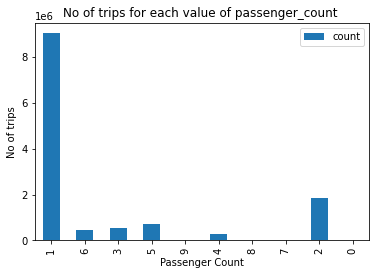

In [0]:
group_df = passenger_grouped.toPandas()
ax = group_df.plot(kind='bar',x='passenger_count',y='count', title = 'No of trips for each value of passenger_count ') 
ax.set_xlabel("Passenger Count")
ax.set_ylabel("No of trips")

**1.What’s special with trips with zero passengers**

These trips do not have anything worth analysing. These trips have mostly 0 trip distance and were charged for that. It means these trips may either be mistakenly booked by the customer or made by the capton to complete his rides.


In [0]:
trips_0 = filtered_df.filter(col('passenger_count')==0)

In [0]:
trips_0.show()

+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|  pickup_longitude|   pickup_latitude|RateCodeID|store_and_fwd_flag| dropoff_longitude|  dropoff_latitude|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|VendorID|
+--------------------+---------------------+---------------+-------------+------------------+------------------+----------+------------------+------------------+------------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------+
| 2015-05-22 02:25:56|  2015-05-22 02:27:56|              0|          0.0|-73.95744323730469|40.687721252441406|         5|             

2.What’s special with trips with more than 6 passengers?

In [0]:
trips_6 = filtered_df.filter(col('passenger_count')>6)

3.What is the largest distance travelled during this month? Is it the first taxi on the moon?

In [0]:
max_dist = filtered_df.agg({"trip_distance": "max"}).collect()


In [0]:
print('Max distance travelled OMG =D : ', max_dist[0][0])

Max distance travelled OMG =D :  15700000.0


4.Plot the distribution of the trip_distance(using an histogram for instance) during year 2105. Focus on trips with non-zero trip distance and trip distance less than 30 miles.

In [0]:
# spark.sparkContext._jvm.System.gc()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

filtered_distance = filtered_df.filter( (col('trip_distance')>0) & (col('trip_distance')<30)).select('trip_distance').collect()
df = filtered_distance.toPandas()
sns.distplot(df.trip_distance)


Py4JJavaError: ignored

# Let’s look at what Spark does for these computations

1.Use the explain method or have a look at the Spark UIto analyze the job. You should be able to assess 
- Parsed Logical Plan
- Analyzed Logical Plan
- Optimized Logical Plan
- Physical Plan


2.Do the Analyzed Logical Plan and Optimized Logical Plan differ? Spot the differences if any.How would a RDBMS proceed with such a query?

3.How does the physical plan differ from the Optimized Logical Plan? What are the keywordsyou would not expects in a RDBMS? What is their meaning?

4.Inspect the stages on Spark UI. How many stages are necessary to complete the Spark job? What are the roles of HashAggregate and Exchange hashpartitioning?

5.Does the physical plan performshuffleoperations? If yes how many?

6.What are tasks with respect to stages (in Spark language)? How many tasks are your stagesmade of?

**Now, compute the following and produce relevant plots:**

1.Break down the trip distance distribution for each day of week

2.Count the number of distinct pickup location

3.Compute and display tips and profits as a function of the pickup location

#4  Investigate one month of trips data in 2015 and 2018


Consider one month of trips data fromyellowtaxis for each year1.Filter and cache/persist the result

## 4.1  Assessing seasonalities and looking at time series

Compute and plot the following time series indexed by day of the week and hour of day:

1. The number of pickups
2. The average fare
3. The average trip duration
4. Plot the average number of ongoing trips

##4.2  Rides to the airports

In order to find the longitude and lattitude of JFK and Newark airport as well as the longitudeand magnitudes of Manhattan, you can use a service like geojson.io. Plot the following time series,indexed the day of the week and hour of the day
1. Median duration of taxi trip leaving Midtown (Southern Manhattan) headed for JFK Airport
2. Median taxi duration of trip leaving from JFK Airport to Midtown (Southern Manhattan)

##4.3  Geographic information

For this, you will need to find tools to display maps and to build choropeth maps. We let you lookand find relevant tools to do this.

1. Build a heatmap where color is a function of
   1. number ofpickups
   2. number ofdropoffs
   3. number ofpickupswith dropoff at some airport (JFK, LaGuardia, Newark)

2. Build a choropeth map where color is a function of
  1. number of pickups in the area
  2. ratio of number of payments by card/number of cash payments for pickups in the area 
  3. ratio of total fare/trip duration for dropoff in the area

3. Build an interactive chorophet with a slider allowing the user to select anhour of dayandwhere the color is a function of
  1. average number of dropoffs in the area during that hour the day 
  2. average ratio of tip over total fare amount for pickups in the area at given hour of theday